# **Part 02:  Détection de Fraudes Bancaires**

## **Chargement et Exploration des données**

In [8]:
# Import des librairies 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  


In [9]:
# Chargement du jeu de données 
data_path = "datasets/data_part2.txt"
# J'enregistre le jeu données en format csv vu que c'est plus pratique, on sait jamais :), les colonnes sont séparées par des ;
df=pd.read_csv(data_path, sep=";") 
#df.to_csv("datasets/fraudes_bancaires.csv", index=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_7096\2278002492.py:4: DtypeWarning: Columns (1,2,5,6,7,8,9,15,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(data_path, sep=";")


In [10]:
# Exploration du dataset

# Dimensions  
print("Dimensions du jeu de données :", df.shape)
# Apercu
print("Aperçu du jeu de données :")
print(df.head())
# Résumé des types 
print(df.info())
# Statistiques descriptives
print("Statistiques descriptives :")
print(df.describe())
# Valeurs manquantes par colonne: 
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Dimensions du jeu de données : (4646774, 23)
Aperçu du jeu de données :
                      ZIBZIN IDAvisAutorisationCheque FlagImpaye  \
0  A013010004908126703060931                 78643044          0   
1  A013011306908024927155000                 78643045          0   
2  A013010002908283134592527                 78643046          0   
3  A011010002908105209831316                 78643047          0   
4  A013010041908000125652029                 78643048          0   

              Montant      DateTransaction CodeDecision VerifianceCPT1  \
0                  20  2017-02-01 07:32:14            1              0   
1                  20  2017-02-01 07:43:37            1              0   
2  57,640000000000001  2017-02-01 07:47:38            1              0   
3  54,289999999999999  2017-02-01 07:48:48            0              1   
4  26,899999999999999  2017-02-01 08:13:27            1              0   

  VerifianceCPT2 VerifianceCPT3 D2CB  ...        TauxImpNb_RB  \
0        

## **Prétraitement des données**

In [11]:
# Typage de la colonne DateTransaction
# On change la colonne de date en format datetime pour pouvoir faire le split temporel
df["DateTransaction"] = pd.to_datetime(df["DateTransaction"], errors="coerce")
# Vérifier qu'on n'a pas trop de NaT
print("Nombre de NaT dans DateTransaction :", df["DateTransaction"].isna().sum())
# On vérifie que le tri chronologique est cohérent
df = df.sort_values("DateTransaction").reset_index(drop=True)
# Contrôle des bornes temporelles
print("Date min :", df["DateTransaction"].min())
print("Date max :", df["DateTransaction"].max())


Nombre de NaT dans DateTransaction : 1
Date min : 2017-02-01 07:32:14
Date max : 2017-11-30 22:07:13


In [12]:
# Vu qu'on a une seule ligne qui ne correspond pas au format datetime, on va la supprimer
df = df.dropna(subset=["DateTransaction"]).reset_index(drop=True)

# petite vérif 
print("Nombre de NaT dans DateTransaction :", df["DateTransaction"].isna().sum())

Nombre de NaT dans DateTransaction : 0


In [13]:
# Séparation des colonnes quantitatives et qualitativesselon la définition dans l'énoncé du projet 
# Colonnes qualitatives : colonnes des identifiants
col_quali = ["ZIBZIN", "IDAvisAutorisationCheque"]

# Colonnes quantitatives : features + cible
col_quanti = [
    "FlagImpaye",
    "Montant",
    "CodeDecision",
    "VerifianceCPT1",
    "VerifianceCPT2",
    "VerifianceCPT3",
    "D2CB",
    "ScoringFP1",
    "ScoringFP2",
    "ScoringFP3",
    "TauxImpNb_RB",
    "TauxImpNB_CPM",
    "EcartNumCheq",
    "NbrMagasin3J",
    "DiffDateTr1",
    "DiffDateTr2",
    "DiffDateTr3",
    "CA3TRetMtt",
    "CA3TR",
    "Heure",
]


In [14]:
# Typage des colonnes selon le type 
# colonnes qualitatives en object : elles y sont déjà
for col in col_quali:
    if col in df.columns:
        df[col] = df[col].astype("object")

# colonnes quantitatives 
# On commence par un nettoyage très simple  :
#    - on remplace les virgules par des points
#    - on convertit en numérique, valeurs invalides -> NaN

for col in col_quanti:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Vérification 
print("\nTypes des colonnes après typage :")
print(df.dtypes)


Types des colonnes après typage :
ZIBZIN                              object
IDAvisAutorisationCheque            object
FlagImpaye                           int64
Montant                            float64
DateTransaction             datetime64[ns]
CodeDecision                         int64
VerifianceCPT1                       int64
VerifianceCPT2                       int64
VerifianceCPT3                       int64
D2CB                                 int64
ScoringFP1                         float64
ScoringFP2                         float64
ScoringFP3                         float64
TauxImpNb_RB                       float64
TauxImpNB_CPM                      float64
EcartNumCheq                         int64
NbrMagasin3J                         int64
DiffDateTr1                        float64
DiffDateTr2                        float64
DiffDateTr3                        float64
CA3TRetMtt                         float64
CA3TR                              float64
Heure              


Distribution de la variable cible FlagImpaye :
FlagImpaye
0    4616778
1      29995
Name: count, dtype: int64
Taux de fraudes (FlagImpaye=1) : 0.65%


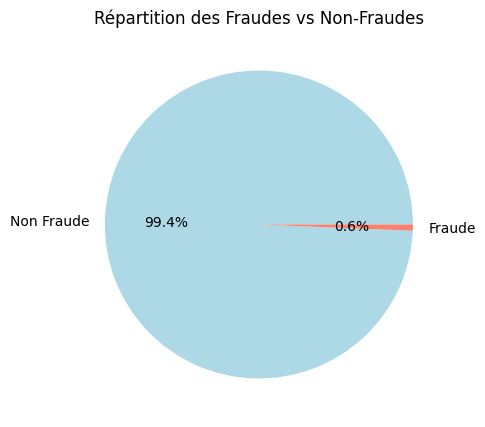

In [15]:
# Maintenant on vérifie la colonne cible et on regarde sa distribution pour detecter le déséquilibre
print("\nDistribution de la variable cible FlagImpaye :")
print(df["FlagImpaye"].value_counts())

# On affiche les pourcentages
fraud_rate = df["FlagImpaye"].mean()
# sous forme de pourcentage 
print(f"Taux de fraudes (FlagImpaye=1) : {fraud_rate*100:.2f}%")

# On fait un petit graphique circulaire pour mieux voir  
plt.figure(figsize=(5, 5))
df["FlagImpaye"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["lightblue", "salmon"],
    labels=["Non Fraude", "Fraude"]
)
plt.ylabel("")  
plt.title("Répartition des Fraudes vs Non-Fraudes")
plt.show()
 

In [16]:
# Split temporel des données train et test 

# Période d'apprentissage : 2017-02-01 au 2017-08-31
start_train = pd.to_datetime("2017-02-01")
end_train   = pd.to_datetime("2017-08-31")

# Période de test : 2017-09-01 au 2017-11-30
start_test = pd.to_datetime("2017-09-01")
end_test   = pd.to_datetime("2017-11-30")

mask_train = (df["DateTransaction"] >= start_train) & (df["DateTransaction"] <= end_train)
mask_test  = (df["DateTransaction"] >= start_test) & (df["DateTransaction"] <= end_test)

train_df = df[mask_train].copy()
test_df  = df[mask_test].copy()

print("Taille train :", train_df.shape)
print("Taille test  :", test_df.shape)


Taille train : (3888468, 23)
Taille test  : (737068, 23)


In [ ]:
# Séparation des features et de la cible

target_col = "FlagImpaye"

# Colonnes à exclure explicitement des features: colonnes non pertiennentes 
cols_to_drop = [
    "FlagImpaye",           # cible
    "CodeDecision",         # info post-transaction, à ne pas utiliser en prédiction
    "IDAvisAutorisationCheque",  # identifiant de transaction
    "ZIBZIN",               # identifiant client/chèque
    "DateTransaction"       # déjà utilisé pour le split, pas forcément utile comme feature brute, de plus ça peut poser des problèmes de fuites temporelles
]

# On garde uniquement les colonnes qui ne sont pas dans cols_to_drop
feature_cols = [c for c in df.columns if c not in cols_to_drop]

print("Nombre de variables explicatives :", len(feature_cols))
print("Liste des variables utilisées :")
print(feature_cols)


In [18]:
# Construction de X et y pour train et test
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()

print("X_train :", X_train.shape, "| y_train :", y_train.shape)
print("X_test  :", X_test.shape,  "| y_test  :", y_test.shape)

X_train : (3888468, 18) | y_train : (3888468,)
X_test  : (737068, 18) | y_test  : (737068,)


## **Choix des modèles**

On a décidé d'utiliser plusieurs familles de modèles afin de comparer leurs performances en détection de fraude sur ce jeu de données fortement déséquilibré. Les modèles sont toujours testés en version **brute** puis avec des **méthodes de prétraitement** adaptées au déséquilibre (sur‑échantillonnage, pondération des classes, et une variante d’undersampling simple).

- **Méthode non paramétrique : K‑plus proches voisins (KNN)**  
  Utilisé seul, puis avec un sur‑échantillonnage de la classe minoritaire (SMOTE) pour améliorer la détection des fraudes.

- **Méthode non linéaire : Forêt aléatoire**  
  Utilisée en version standard, puis avec une approche cost‑sensitive via `class_weight` pour mieux tenir compte du déséquilibre de classes. Une deuxième variante avec undersampling de la classe majoritaire pour comparer l’impact de la réduction du nombre de transactions non frauduleuses.

- **Méthode linéaire : Régression logistique**  
  Baseline linéaire, testée brute puis avec `class_weight` pour pondérer davantage la classe fraude, et finalement avec une méthode de sur-échantillonnage (ADASYN).

- **Méthode non supervisée : k‑means**  
  Utilisée pour repérer des clusters de transactions atypiques, sans utiliser directement la cible pendant l’apprentissage.

- **Méthode ensembliste : XGBoost**                                                 
  Modèle de gradient boosting d’arbres de décision testé comme méthode ensembliste, avec prise en compte du déséquilibre via une pondération renforcée de la classe fraude.


## **Entrainement et Evaluation des modèles**

### **Méthodes non paramétriques: KNN**

In [19]:
# On commence par le KNN brut, notre baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

# Vu que le KNN calcule les distances entre TOUS les points, ce qui peut etre lent avec notre dataset, on va sous-échantillonner les données pour le tester
# sous-échantillonage train 
n_train_sub = 400_000
train_sample = train_df.sample(n=n_train_sub, random_state=42)

X_train_knn = train_sample[feature_cols].copy()
y_train_knn = train_sample[target_col].copy()

# sous-échantillonage test 
n_test_sub = 100_000  
test_sample = test_df.sample(n=n_test_sub, random_state=42)

X_test_knn = test_sample[feature_cols].copy()
y_test_knn = test_sample[target_col].copy()

# on utilise des pipelines, c'est plus propre
# On prend un KNN avec k=5 et pondération par distance
# On standardise les données avant, c'est hyper important pour le KNN vu qu'il se base sur les distances
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])

# Entraînement
knn_pipeline.fit(X_train_knn, y_train_knn)

# Prédiction
y_pred_knn = knn_pipeline.predict(X_test_knn)

# Évaluation
print("KNN brut (train/test sous-échantillonnés) - F1-score (classe fraude = 1) :",
      f1_score(y_test_knn, y_pred_knn, pos_label=1))

print("\nRapport de classification KNN brut :")
print(classification_report(y_test_knn, y_pred_knn, digits=3))


KNN brut (train/test sous-échantillonnés) - F1-score (classe fraude = 1) : 0.019629225736095966

Rapport de classification KNN brut :
              precision    recall  f1-score   support

           0      0.991     1.000     0.995     99140
           1      0.158     0.010     0.020       860

    accuracy                          0.991    100000
   macro avg      0.575     0.505     0.508    100000
weighted avg      0.984     0.991     0.987    100000



**Interprétation:**

Le KNN brut obtient une accuracy globale très élevée (~99 %), mais cela s’explique par le fort déséquilibre du jeu de données, la quasi-totalité des transactions sont non frauduleuses, et le modèle prédit principalement la classe 0.

Pour la classe non fraude, la précision et le rappel sont presque parfaits (F1 ≈ 0.995), ce qui montre que le modèle sait très bien reconnaître les transactions normales.

En revanche, pour la classe fraude, les performances sont très mauvaises, le rappel est quasiment nul (~1%) et le F1-score est proche de 0.02. Autrement dit, le KNN brut rate l’immense majorité des fraudes et ne constitue pas un modèle exploitable pour la détection de la classe minoritaire! ça ne vaut pas le coup a ce stade d'optimiser le K.

On verra ce que ça donne avec le SMOTE


In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# On utilisera les memes sous-échantillons que pour le KNN brut a fin de comparer proprement 

# pipeline KNN + SMOTE
knn_smote_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])

# Entraînement
knn_smote_pipeline.fit(X_train_knn, y_train_knn)

# Prédiction
y_pred_knn_smote = knn_smote_pipeline.predict(X_test_knn)

# Évaluation
print("KNN + SMOTE (train/test sous-échantillonnés) - F1-score (classe fraude = 1) :",
      f1_score(y_test_knn, y_pred_knn_smote, pos_label=1))

print("\nRapport de classification KNN + SMOTE :")
print(classification_report(y_test_knn, y_pred_knn_smote, digits=3))


KNN + SMOTE (train/test sous-échantillonnés) - F1-score (classe fraude = 1) : 0.031998222320982164

Rapport de classification KNN + SMOTE :
              precision    recall  f1-score   support

           0      0.993     0.830     0.904     99140
           1      0.017     0.335     0.032       860

    accuracy                          0.826    100000
   macro avg      0.505     0.582     0.468    100000
weighted avg      0.985     0.826     0.897    100000



**Interprétation:**

Avec SMOTE, le KNN détecte plus de fraudes (rappel fraude ≈ "33,5"% au lieu de 1%), mais au prix d’une précision très faible (~1.7%) et d’une baisse nette de l’accuracy (~82.6%).

Le F1‑score fraude ne passe que d’environ 0.019 à 0.032, ce qui reste très faible AS EXPECTED. 

Je pense que le KNN n’est pas adapté pour ce problème de fraude très déséquilibré.

On verra ce que ça donne avec le reste des méthodes

## **Méthodes non linéaires : Forêt aléatoire**

In [21]:
# Random Forest brut 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# On commence avec cette config pour tester, on fera du tuning après si besoin 
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)


# Contrairement au KNN, on peut utiliser tout le dataset, les forêts aléatoires sont beauuucoup plus scalables
# Entraînement
rf_base.fit(X_train, y_train)

# Prédiction
y_pred_rf_base = rf_base.predict(X_test)

# Évaluation
print("Random Forest brut - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_rf_base, pos_label=1))

print("\nRapport de classification RF brut :")
print(classification_report(y_test, y_pred_rf_base, digits=3))


Random Forest brut - F1-score (classe fraude = 1) : 0.03487672880336741

Rapport de classification RF brut :
              precision    recall  f1-score   support

           0      0.991     1.000     0.996    730583
           1      0.695     0.018     0.035      6485

    accuracy                          0.991    737068
   macro avg      0.843     0.509     0.515    737068
weighted avg      0.989     0.991     0.987    737068



**Interprétation:**

La forêt aléatoire brute obtient une excellente performance sur la classe non fraude (F1 ≈ 0.996) et une accuracy globale de ~99 %, mais elle détecte très peu de fraudes (rappel ≈ 1,8 %, F1 ≈ 0,035). Comme pour KNN brut, le modèle se concentre surtout sur la classe majoritaire et reste inadapté à la détection efficace de la classe minoritaire.


In [22]:
# Maintenant on teste une Random Forest avec pondération des classes (cost-sensitive) pour gérer le déséquilibre
rf_bal = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"   # pondère plus la classe fraude
)

# Entraînement
rf_bal.fit(X_train, y_train)

# Prédiction
y_pred_rf_bal = rf_bal.predict(X_test)

# Évaluation
print("Random Forest balanced - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_rf_bal, pos_label=1))

print("\nRapport de classification RF balanced :")
print(classification_report(y_test, y_pred_rf_bal, digits=3))


Random Forest balanced - F1-score (classe fraude = 1) : 0.045528479004529505

Rapport de classification RF balanced :
              precision    recall  f1-score   support

           0      0.994     0.825     0.902    730583
           1      0.024     0.481     0.046      6485

    accuracy                          0.822    737068
   macro avg      0.509     0.653     0.474    737068
weighted avg      0.986     0.822     0.895    737068



**Interprétation:**

C’est nettement mieux pour la classe fraude (même si ça reste faible en absolu, mais c'était attendu vu le type de problème) 

Avec `class_weight="balanced"`, RF détecte beaucoup plus de fraudes : le rappel de la classe 1 passe d’environ 1,4 % (RF brut) à 48,1 %, et le F1-score fraude est augmenté (de ~0,035 à ~0,046). En contrepartie, l’accuracy globale chute à ~82,2 % et la précision sur la classe fraude devient très faible (~2,4 %), car le modèle génère davantage de faux positifs. Cette variante cost-sensitive illustre bien le compromis classique en fraude entre meilleure détection des cas frauduleux et augmentation du nombre d’alertes à traiter.

In [23]:
# Testons maintenant le Random Forest avec une méthode de undersampling pour voir ce que ça donne 
from imblearn.under_sampling import RandomUnderSampler

rf_rus_pipeline = ImbPipeline([
    ("under", RandomUnderSampler(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    ))
])

# Entraînement 
rf_rus_pipeline.fit(X_train, y_train)

# Prédiction 
y_pred_rf_rus = rf_rus_pipeline.predict(X_test)

# Évaluation

print("Random Forest + undersampling - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_rf_rus, pos_label=1))

print("\nRapport de classification RF + undersampling :")
print(classification_report(y_test, y_pred_rf_rus, digits=3))


Random Forest + undersampling - F1-score (classe fraude = 1) : 0.034167285502651884

Rapport de classification RF + undersampling :
              precision    recall  f1-score   support

           0      0.996     0.652     0.788    730583
           1      0.018     0.699     0.034      6485

    accuracy                          0.652    737068
   macro avg      0.507     0.675     0.411    737068
weighted avg      0.987     0.652     0.781    737068



**Interprétation:**

L’undersampling permet à la forêt aléatoire d’atteindre un rappel très élevé sur la classe fraude (~70 %), mais avec une précision extrêmement faible (~1,8 %) et une accuracy globale d’environ 65 %. Le modèle déclenche donc énormément de fausses alertes.

### **Méthodes linéaires: Régression logistique**

In [24]:
# Régression logistique brute

from sklearn.linear_model import LogisticRegression

# On utilise la régularisation L2 Ridge pour éviter l'overfitting, avec le solver lbfgs qui est adapté aux grands datasets et on standardise comme dhab 
logreg_base = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1
    ))
])

# Entraînement
logreg_base.fit(X_train, y_train)

# Prédiction
y_pred_logreg_base = logreg_base.predict(X_test)

# Évaluation
print("LogReg brute - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_logreg_base, pos_label=1))

print("\nRapport de classification LogReg brute :")
print(classification_report(y_test, y_pred_logreg_base, digits=3))


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LogReg brute - F1-score (classe fraude = 1) : 0.004279382546232615

Rapport de classification LogReg brute :
              precision    recall  f1-score   support

           0      0.991     1.000     0.996    730583
           1      0.241     0.002     0.004      6485

    accuracy                          0.991    737068
   macro avg      0.616     0.501     0.500    737068
weighted avg      0.985     0.991     0.987    737068



In [25]:
# Régression logistique cost-sensitive

logreg_bal = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# Entraînement
logreg_bal.fit(X_train, y_train)

# Prédiction
y_pred_logreg_bal = logreg_bal.predict(X_test)

# Évaluation
print("LogReg balanced - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_logreg_bal, pos_label=1))

print("\nRapport de classification LogReg balanced :")
print(classification_report(y_test, y_pred_logreg_bal, digits=3))


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LogReg balanced - F1-score (classe fraude = 1) : 0.03864947997572191

Rapport de classification LogReg balanced :
              precision    recall  f1-score   support

           0      0.995     0.748     0.854    730583
           1      0.020     0.579     0.039      6485

    accuracy                          0.746    737068
   macro avg      0.508     0.664     0.446    737068
weighted avg      0.986     0.746     0.847    737068



**Interprétation:**

Avec la pondération des classes, la régression logistique passe d’un modèle qui ignore presque totalement les fraudes (rappel ≈ 0,2 %) à un modèle qui en détecte beaucoup plus (rappel ≈ 60 %), mais au prix d’une avalanche de faux positifs et d’une chute de l’accuracy (~75 %).

In [26]:
# Essayons maintenant une régression logistique avec oversampling ADASYN vu qu'on l'a pas encore testé
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline  #  pipeline d'imblearn 


logreg_adasyn = Pipeline([
    ("scaler", StandardScaler()),
    ("adasyn", ADASYN(random_state=42)),
    ("logreg", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1
    ))
])

# Entraînement
logreg_adasyn.fit(X_train, y_train)

# Prédiction
y_pred_logreg_adasyn = logreg_adasyn.predict(X_test)

# Évaluation
print("LogReg ADASYN - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_logreg_adasyn, pos_label=1))

print("\nRapport de classification LogReg ADASYN :")
print(classification_report(y_test, y_pred_logreg_adasyn, digits=3))


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LogReg ADASYN - F1-score (classe fraude = 1) : 0.037026707315900326

Rapport de classification LogReg ADASYN :
              precision    recall  f1-score   support

           0      0.995     0.729     0.842    730583
           1      0.019     0.594     0.037      6485

    accuracy                          0.728    737068
   macro avg      0.507     0.662     0.439    737068
weighted avg      0.986     0.728     0.835    737068



**Interprétation:**

Avec ADASYN, la régression logistique devient agressive sur la détection de fraude (rappel ≈ 59 %), mais au prix d’une précision quasi nulle et d’une accuracy globale  (~72 %). Le modèle génère donc énormément de faux positifs!

### **Méthodes non supervisées: K-means**

In [27]:
# On va quand meme tester le K-means comme il est beaucoup utilisé en détection de fraudes 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Standardisation 
scaler_km = StandardScaler()
X_train_km = scaler_km.fit_transform(X_train)
X_test_km  = scaler_km.transform(X_test)

#  K-means ( 2 clusters : comportement "normal" vs "atypique")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train_km)

# Score d'anomalie = distance au centroïde le plus proche (plus la distance est grande, plus c'est suspect)
dist_train = kmeans.transform(X_train_km).min(axis=1)
dist_test  = kmeans.transform(X_test_km).min(axis=1) 

# On marque comme "fraude" les 0.5%  des points les plus éloignés
seuil = np.quantile(dist_train, 0.995)  

y_pred_km = (dist_test > seuil).astype(int)  

print("KMeans anomaly - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_km, pos_label=1))

print("\nRapport de classification KMeans anomaly :")
print(classification_report(y_test, y_pred_km, digits=3))

# On calcule aussi la AUC en utilisant la distance comme score
auc_km = roc_auc_score(y_test, dist_test)
print("KMeans anomaly - AUC :", auc_km)


KMeans anomaly - F1-score (classe fraude = 1) : 0.06449351559761654

Rapport de classification KMeans anomaly :
              precision    recall  f1-score   support

           0      0.992     0.994     0.993    730583
           1      0.075     0.057     0.064      6485

    accuracy                          0.986    737068
   macro avg      0.533     0.525     0.529    737068
weighted avg      0.984     0.986     0.985    737068

KMeans anomaly - AUC : 0.6199175234152069


**Interprétation:**

K-means est utilisé ici comme méthode non supervisée : on apprend les centroïdes sur le train, puis on mesure, sur le test, la distance de chaque transaction à son centroïde le plus proche. Les points trop éloignés sont marqués comme « anomalies » (fraudes).

Cette approche donne une très bonne reconnaissance des transactions normales (precision/rappel ≈ 0,99 pour la classe 0), mais une détection limitée des fraudes (F1 ≈ 0,064, AUC ≈ 0,62). Elle montre que le clustering capte un peu le comportement atypique des fraudes, mais reste nettement moins performant que les modèles supervisés (avec méthodes de prétraitement pour le déséquilibre) pour ce task.

## **Méthodes ensemblistes: XGBoost**

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report



xgb_brut = XGBClassifier(
    objective="binary:logistic",
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    device="cuda:1"   
)

# Entraînement
xgb_brut.fit(X_train, y_train)

# Prédiction
y_pred_xgb_brut = xgb_brut.predict(X_test)

# Évaluation
print("XGBoost brut - F1 fraude :",
      f1_score(y_test, y_pred_xgb_brut, pos_label=1))

print("\nRapport de classification XGBoost brut :")
print(classification_report(y_test, y_pred_xgb_brut, digits=3))


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:53: Only 1 GPUs are visible, setting device ordinal to 0
  warnings.warn(smsg, UserWarning)
c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost brut - F1 fraude : 0.07570977917981073

Rapport de classification XGBoost brut :
              precision    recall  f1-score   support

           0      0.992     1.000     0.996    730583
           1      0.540     0.041     0.076      6485

    accuracy                          0.991    737068
   macro avg      0.766     0.520     0.536    737068
weighted avg      0.988     0.991     0.988    737068



**Interprétation:**

Parmi tous les modèles bruts (sans pondération, sans rééquilibrage), XGBoost est celui qui obtient le meilleur F1 sur la fraude (≈ 0,076), tout en conservant une excellente performance sur la classe normale. Cela montre que, même sans traitement du déséquilibre, une méthode ensembliste comme XGBoost exploite mieux la structure des données que les autres modèles de base, mais reste insuffisante pour une détection de fraude efficace, mais encore une fois on s'attendait à ça!

In [29]:
# Essayons une approche cost‑sensitive par ré‑pondération des classes avec XGBoost

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,
    random_state=42,
    # GPU
    device="cuda:1"          # pour qu'il utilise mon gpu 
)

xgb.fit(X_train, y_train)

y_pred_xgb_gpu = xgb.predict(X_test)

print("XGBoost GPU - F1 fraude :",
      f1_score(y_test, y_pred_xgb_gpu, pos_label=1))
print(classification_report(y_test, y_pred_xgb_gpu, digits=3))

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:53: Only 1 GPUs are visible, setting device ordinal to 0
  warnings.warn(smsg, UserWarning)


XGBoost GPU - F1 fraude : 0.12975711846670707
              precision    recall  f1-score   support

           0      0.993     0.986     0.989    730583
           1      0.101     0.182     0.130      6485

    accuracy                          0.979    737068
   macro avg      0.547     0.584     0.559    737068
weighted avg      0.985     0.979     0.982    737068



**Interprétation:**

Avec ce réglage cost sensitive, XGBoost améliore nettement la détection des fraudes par rapport au modèle brut : le F1 fraude passe à ≈ 0,13 avec un rappel d’environ 18%, tout en restant très bon sur la classe normale (F1 ≈ 0,99), mais au prix d'une hausse des faux positifs.

## **Tuning des meilleurs modèles**

**Les deux meilleurs modèles sont le Random Forest et le XGBoost**

### **Random Forest:**

In [30]:
# Testons cette config de Random Forest avec une pénalisation plus forte des erreurs sur la classe positive (fraude) pour voir si ça améliore les résultats
rf_tuned_1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
    class_weight={0:1, 1:20} #On pénalise fortement les erreurs sur la classe positive
)

# Entraînement
rf_tuned_1.fit(X_train, y_train)

# Prédiction
y_pred_rf_tuned_1 = rf_tuned_1.predict(X_test)

# Évaluation
print("Random Forest balanced tuned - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_rf_tuned_1, pos_label=1))

print("\nRapport de classification RF balanced tuned :")
print(classification_report(y_test, y_pred_rf_tuned_1, digits=3))


Random Forest balanced tuned - F1-score (classe fraude = 1) : 0.10725765521908306

Rapport de classification RF balanced tuned :
              precision    recall  f1-score   support

           0      0.992     0.994     0.993    730583
           1      0.119     0.098     0.107      6485

    accuracy                          0.986    737068
   macro avg      0.555     0.546     0.550    737068
weighted avg      0.984     0.986     0.985    737068



**Interprétation:**

En augmentant la pénalisation de la fraude (class_weight={0:1, 1:20}), la Random Forest détecte un peu mieux les fraudes qu’en version brute ou simplement balanced (F1 fraude ≈ 0.107 contre 0.034 et 0.045).

In [ ]:
# On essaye d'optimiser les hyperparamètres du RF avec une recherche aléatoire (RandomizedSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

rf_base = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)

# On définit une grille de recherche pour les hyperparamètres les plus importants du RF
param_dist = {
    "n_estimators": [100, 200],          
    "max_depth": [10, 15, None],        
    "min_samples_leaf": [1, 2, 5],      
    "max_features": ["sqrt", "log2"]    
}

f1_fraud_scorer = make_scorer(f1_score, pos_label=1)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=10,      
    scoring=f1_fraud_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42,
)

rf_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres RF (F1 fraude) :")
print(rf_search.best_params_)

best_rf = rf_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("RF balanced (tuned) - F1 fraude :",
      f1_score(y_test, y_pred_best, pos_label=1))

print("\nRapport de classification RF balanced (tuned) :")
print(classification_report(y_test, y_pred_best, digits=3))


'\n# On essaye d\'optimiser les hyperparamètres du RF avec une recherche aléatoire (RandomizedSearchCV)\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import make_scorer\n\nrf_base = RandomForestClassifier(\n    n_jobs=-1,\n    random_state=42,\n    class_weight="balanced"\n)\n\n# On définit une grille de recherche pour les hyperparamètres les plus importants du RF\nparam_dist = {\n    "n_estimators": [100, 200],          \n    "max_depth": [10, 15, None],        \n    "min_samples_leaf": [1, 2, 5],      \n    "max_features": ["sqrt", "log2"]    \n}\n\nf1_fraud_scorer = make_scorer(f1_score, pos_label=1)\n\nrf_search = RandomizedSearchCV(\n    rf_base,\n    param_distributions=param_dist,\n    n_iter=10,      \n    scoring=f1_fraud_scorer,\n    cv=3,\n    n_jobs=-1,\n    random_state=42,\n)\n\nrf_search.fit(X_train, y_train)\n\nprint("Meilleurs hyperparamètres RF (F1 fraude) :")\nprint(rf_search.best_pa

**Le temps de calcul a été très long et mon PC a fini par planter :( mais ça aurait été une méthode plus efficace pour optimiser les hyperparamètres**

In [32]:
# Vu que la recherche aléatoire n'a pas donné de résultats, testons cette deuxième config 
rf_tuned_2 = RandomForestClassifier(
    n_estimators=300,        # plus d’arbres pour stabiliser
    max_depth=15,          
    min_samples_leaf=2,     
    max_features="sqrt",    
    n_jobs=-1,
    random_state=42,
    class_weight={0: 1, 1: 10}   
)

rf_tuned_2.fit(X_train, y_train)

y_pred_rf_tuned_2 = rf_tuned_2.predict(X_test)

print("Random Forest tuned - F1-score (classe fraude = 1) :",
      f1_score(y_test, y_pred_rf_tuned_2, pos_label=1))

print("\nRapport de classification RF tuned :")
print(classification_report(y_test, y_pred_rf_tuned_2, digits=3))


Random Forest tuned - F1-score (classe fraude = 1) : 0.09688899093100678

Rapport de classification RF tuned :
              precision    recall  f1-score   support

           0      0.992     0.998     0.995    730583
           1      0.190     0.065     0.097      6485

    accuracy                          0.989    737068
   macro avg      0.591     0.531     0.546    737068
weighted avg      0.985     0.989     0.987    737068



**Interprétation:**

Malgré plus d’arbres, une profondeur plus grande et une pondération modérée de la fraude (class_weight={0:1,1:10}), elle fait un peu moins bien que la version fortement pondérée ({0:1,1:20}) pour la détection de fraude.

### **XGBoost:**

In [33]:
# Maintenant, en plus des poids pondérés, on va essayer d'optimiser le seuil de décision pour maximiser le F1-score 
xgb_tuned_1 = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,
    random_state=42,
    device="cuda:1"
)
xgb_tuned_1.fit(X_train, y_train)

# On récupère les probabilités pour la classe 1
y_proba = xgb_tuned_1.predict_proba(X_test)[:, 1]

# On cherche le meilleur seuil pour le F1 fraude
best_th = 0.5
best_f1 = 0.0

for th in np.linspace(0.01, 0.99, 99):
    y_pred_th = (y_proba >= th).astype(int)
    f1 = f1_score(y_test, y_pred_th, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"Meilleur seuil F1 fraude : {best_th:.2f}, F1 = {best_f1:.3f}")

# Évaluation finale avec ce seuil
y_pred_xgb_tuned_1 = (y_proba >= best_th).astype(int)
print(classification_report(y_test, y_pred_xgb_tuned_1, digits=3))


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:53: Only 1 GPUs are visible, setting device ordinal to 0
  warnings.warn(smsg, UserWarning)


Meilleur seuil F1 fraude : 0.63, F1 = 0.142
              precision    recall  f1-score   support

           0      0.992     0.995     0.994    730583
           1      0.172     0.121     0.142      6485

    accuracy                          0.987    737068
   macro avg      0.582     0.558     0.568    737068
weighted avg      0.985     0.987     0.986    737068



**Interprétation:**

Avec XGBoost pondéré (scale_pos_weight=10) et un **seuil optimisé pour le F1 fraude (0.63)**, le modèle atteint un F1 fraude d’environ 0.142, nettement supérieur aux versions brutes ou uniquement pondérés. Il reste excellent sur la classe non fraude (F1 ≈ 0.994) et parvient à détecter davantage de fraudes (rappel ≈ 12%) tout en gardant une précision raisonnable (≈ 17%).



In [34]:
# On essaye d'améliorer encore les résultats de XGBoost en testant une config plus agressive pour la classe positive (fraude) et en recalibrant le seuil pour maximiser le F1 sur la classe fraude
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

xgb_tuned_2 = XGBClassifier(
    n_estimators=500,      # plus d’arbres
    max_depth=4,          # moins profonds 
    learning_rate=0.05,   # un peu plus petit
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=20,  # plus de poids à la fraude
    objective="binary:logistic",
    random_state=42,
    device="cuda:1"
)

xgb_tuned_2.fit(X_train, y_train)

y_proba_try = xgb_tuned_2.predict_proba(X_test)[:, 1]

# recalibrage du seuil pour F1
best_th = 0.5
best_f1 = 0.0

for th in np.linspace(0.01, 0.99, 99):
    y_pred_th = (y_proba_try >= th).astype(int)
    f1 = f1_score(y_test, y_pred_th, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"Meilleur seuil F1  : {best_th:.2f}, F1 = {best_f1:.3f}")

y_pred_xgb_tuned_2 = (y_proba_try >= best_th).astype(int)
print(classification_report(y_test, y_pred_xgb_tuned_2, digits=3))


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:53: Only 1 GPUs are visible, setting device ordinal to 0
  warnings.warn(smsg, UserWarning)


Meilleur seuil F1  : 0.72, F1 = 0.147
              precision    recall  f1-score   support

           0      0.992     0.993     0.993    730583
           1      0.150     0.145     0.147      6485

    accuracy                          0.985    737068
   macro avg      0.571     0.569     0.570    737068
weighted avg      0.985     0.985     0.985    737068



**Interprétation:**

Avec cette configuration (plus d’arbres, profondeur réduite, `learning_rate` plus faible et `scale_pos_weight=20`), XGBoost obtient son **meilleur F1 fraude** jusque‑là (≈ 0.147), tout en restant très bon sur la classe normale (F1 ≈ 0.993). Le seuil optimal plus élevé (0.72) donne un compromis où le modèle détecte davantage de fraudes qu’avec la version brute ou les premières config pondérées (rappel ≈ 14.5%) tout en gardant une précision correcte (≈ 15%), ce qui en fait ta configuration la plus convaincante pour la détection de fraude dans ce projet.


In [ ]:
#Recherche des meilleurs hyperparamètres pour XGBoost avec RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report
import numpy as np


xgb_base = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    device="cuda:1"
)


param_dist = {
    "n_estimators":    [200, 300],      
    "max_depth":       [3, 4, 5],        
    "learning_rate":   [0.05, 0.1],       
    "subsample":       [0.8, 1.0],
    "colsample_bytree":[0.8, 1.0],
    "scale_pos_weight":[8, 10, 15, 20]
}

f1_fraud_scorer = make_scorer(f1_score, pos_label=1)

xgb_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=8,              
    scoring=f1_fraud_scorer,
    cv=2,                  
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres XGB:")
print(xgb_search.best_params_)

best_xgb = xgb_search.best_estimator_

# 3) Optimisation du seuil pour le meilleur modèle
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

best_th = 0.5
best_f1 = 0.0

for th in np.linspace(0.01, 0.99, 99):
    y_pred_th = (y_proba_best >= th).astype(int)
    f1 = f1_score(y_test, y_pred_th, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"Meilleur seuil F1 fraude (best XGB) : {best_th:.2f}, F1 = {best_f1:.3f}")

y_pred_best = (y_proba_best >= best_th).astype(int)
print(classification_report(y_test, y_pred_best, digits=3))

'\n#Recherche des meilleurs hyperparamètres pour XGBoost avec RandomizedSearchCV\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import f1_score, make_scorer, classification_report\nimport numpy as np\n\n\nxgb_base = XGBClassifier(\n    objective="binary:logistic",\n    random_state=42,\n    device="cuda:1"\n)\n\n\nparam_dist = {\n    "n_estimators":    [200, 300],      \n    "max_depth":       [3, 4, 5],        \n    "learning_rate":   [0.05, 0.1],       \n    "subsample":       [0.8, 1.0],\n    "colsample_bytree":[0.8, 1.0],\n    "scale_pos_weight":[8, 10, 15, 20]\n}\n\nf1_fraud_scorer = make_scorer(f1_score, pos_label=1)\n\nxgb_search = RandomizedSearchCV(\n    xgb_base,\n    param_distributions=param_dist,\n    n_iter=8,              \n    scoring=f1_fraud_scorer,\n    cv=2,                  \n    n_jobs=-1,\n    random_state=42,\n    verbose=1\n)\n\nxgb_search.fit(X_train, y_train)\n\nprint("Meilleurs hyperparamètres

**Pareil la recherche avec RandomizedSearchCV n'a pas aboutit en raison des ressources, mais au moins on a essayé :)** 

## **Synthèse des performances des modèles** 

In [39]:
# On construit un tableau récapitulatif des résultats de tous les modèles testés  pour comparer facilement leurs performances
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

rows = []

def add_model_result(name, pretraitement, y_true, y_pred):
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1, zero_division=0
    )
    rows.append({
        "Modèle": name,
        "Prétraitement": pretraitement,
        "F1 fraude": f1,
        "Précision fraude": prec,
        "Rappel fraude": rec,
    })

add_model_result("KNN brut (subset)", "Aucun", y_test_knn, y_pred_knn)
add_model_result("KNN + SMOTE (subset)", "SMOTE", y_test_knn, y_pred_knn_smote)
add_model_result("RF brut", "Aucun", y_test, y_pred_rf_base)
add_model_result('RF class_weight="balanced"', "Pondération auto", y_test, y_pred_rf_bal)
add_model_result("RF + undersampling", "RandomUnderSampler", y_test, y_pred_rf_rus)
add_model_result("RF cw {0:1,1:20}", "Pondération forte fraude", y_test, y_pred_rf_tuned_1)
add_model_result("RF tuned {0:1,1:10}", "Pondération modérée + tuning", y_test, y_pred_rf_tuned_2)
add_model_result("LogReg brut", "Aucun", y_test, y_pred_logreg_base)
add_model_result("LogReg balanced", "Pondération auto", y_test, y_pred_logreg_bal)
add_model_result("LogReg ADASYN", "ADASYN", y_test, y_pred_logreg_adasyn)
add_model_result("KMeans anomaly", "Seuil sur distance au centroïde", y_test, y_pred_km)
add_model_result("XGBoost brut", "Aucun", y_test, y_pred_xgb_brut)
add_model_result("XGBoost cw10", "scale_pos_weight=10", y_test, y_pred_xgb_gpu)
add_model_result("XGBoost cw10 + seuil", "scale_pos_weight=10 + seuil F1", y_test, y_pred_xgb_tuned_1)
add_model_result("XGBoost cw20 + seuil", "scale_pos_weight=20 + seuil F1", y_test, y_pred_xgb_tuned_2)

df_results = pd.DataFrame(rows)
print(df_results)


                        Modèle                    Prétraitement  F1 fraude  \
0            KNN brut (subset)                            Aucun   0.019629   
1         KNN + SMOTE (subset)                            SMOTE   0.031998   
2                      RF brut                            Aucun   0.034877   
3   RF class_weight="balanced"                 Pondération auto   0.045528   
4           RF + undersampling               RandomUnderSampler   0.034167   
5             RF cw {0:1,1:20}         Pondération forte fraude   0.107258   
6          RF tuned {0:1,1:10}     Pondération modérée + tuning   0.096889   
7                  LogReg brut                            Aucun   0.004279   
8              LogReg balanced                 Pondération auto   0.038649   
9                LogReg ADASYN                           ADASYN   0.037027   
10              KMeans anomaly  Seuil sur distance au centroïde   0.064494   
11                XGBoost brut                            Aucun 

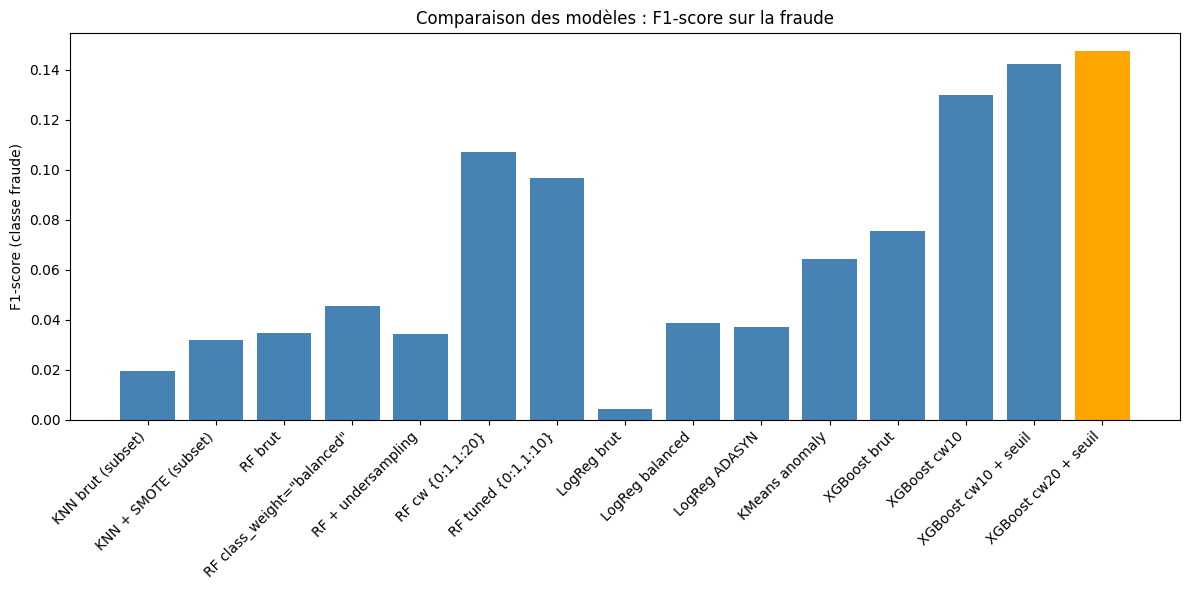

In [ ]:
# Graphique en barres pour comparer les F1-scores sur la classe fraude des différents modèles testés
import matplotlib.pyplot as plt


f1_values = df_results["F1 fraude"].values
models = df_results["Modèle"].values


best_idx = np.argmax(f1_values)

colors = ["steelblue"] * len(f1_values)
colors[best_idx] = "orange"   # couleur différente pour le meilleur

plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_values)), f1_values, color=colors)
plt.xticks(range(len(f1_values)), models, rotation=45, ha="right")
plt.ylabel("F1-score (classe fraude)")
plt.title("Comparaison des modèles : F1-score sur la fraude")
plt.tight_layout()
plt.savefig("graphique_f1_fraude.png", dpi=300)
plt.show()



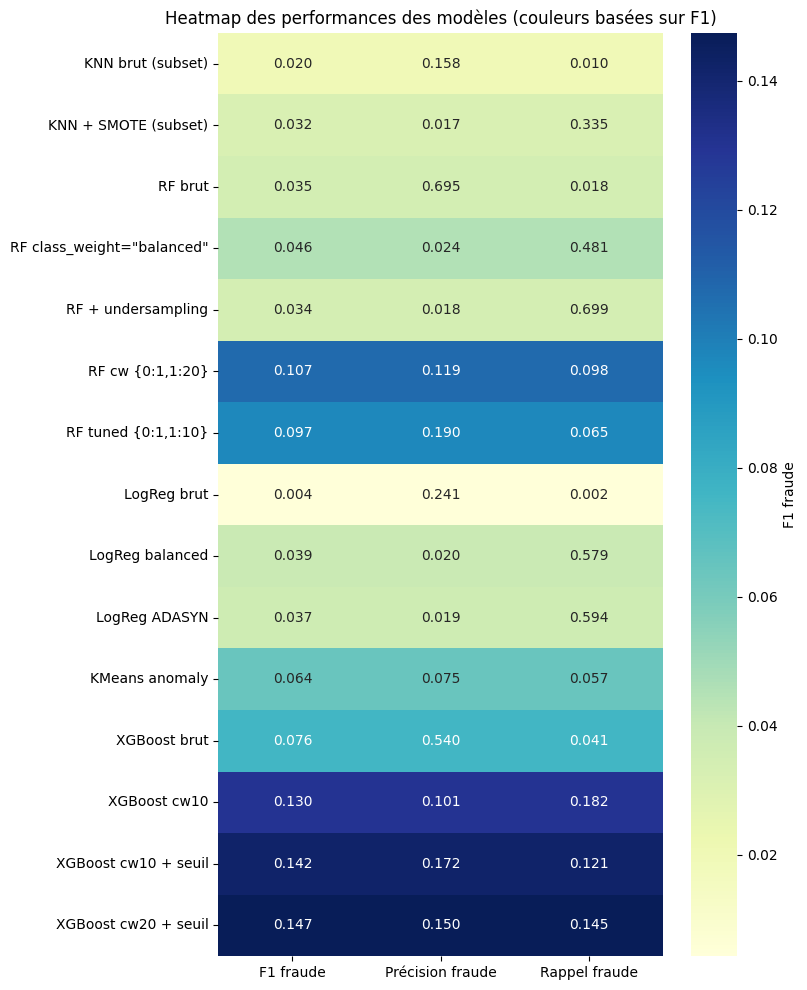

In [ ]:
# Heatmap des performances pour les différents modèles 
import seaborn as sns


# On garde les trois métriques pour les annotations
df_heatmap = df_results.set_index("Modèle")[["F1 fraude", "Précision fraude", "Rappel fraude"]]

# Les couleurs sont uniquement basées sur F1 :
color_matrix = np.repeat(df_heatmap[["F1 fraude"]].values, 3, axis=1)

plt.figure(figsize=(8, 10))
sns.heatmap(
    color_matrix,
    annot=df_heatmap.values,      
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={"label": "F1 fraude"},
    yticklabels=df_heatmap.index,
    xticklabels=["F1 fraude", "Précision fraude", "Rappel fraude"]
)
plt.title("Heatmap des performances des modèles (couleurs basées sur F1)")
plt.tight_layout()
plt.savefig("heatmap_performances_f1_only.png", dpi=300)
plt.show()
